In [ ]:
import random
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from google.colab import drive
import json
import requests
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [ ]:
drive.mount("/content/drive")
train_img_dir = './drive/MyDrive/crackTrain'
test_img_dir = './drive/MyDrive/crackTest'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


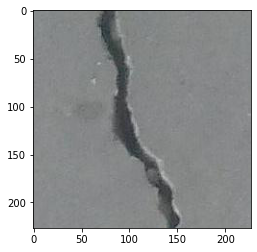

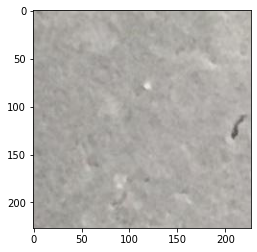

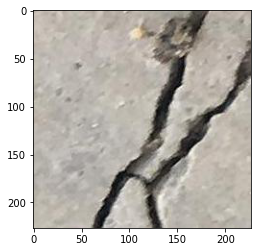

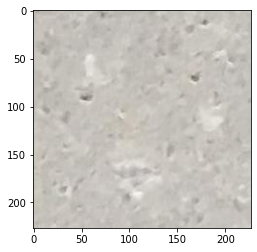

In [ ]:
img_files = [os.path.join(train_img_dir, 'true/00001.jpg'),
             os.path.join(train_img_dir, 'false/00001.jpg'),
             os.path.join(test_img_dir, 'true/01001.jpg'),
             os.path.join(test_img_dir, 'false/01001.jpg')]

for img in img_files:
    plt.imshow(np.asarray(Image.open(img)))
    plt.show()

In [ ]:
train_df = []


for i in range(1, 501):
  imgNum = "0"*(5 - len(str(i))) + str(i) + ".jpg"
  trueImg = "true/" + imgNum
  truePath = os.path.join(train_img_dir, trueImg)
  imgArr = np.asarray(Image.open(truePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  train_df.append(flattened)


for i in range(1, 501):
  imgNum = "0"*(5 - len(str(i))) + str(i) + ".jpg"
  falseImg = "false/" + imgNum
  falsePath = os.path.join(train_img_dir, falseImg)
  imgArr = np.asarray(Image.open(falsePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  train_df.append(flattened)


train_df = pd.DataFrame(train_df)
train_df.loc[train_df.index[:500], 'label'] = 1
train_df.loc[train_df.index[500:], 'label'] = 0

train_df = train_df.sample(frac=1)
train_df

,0,1,2,3,4,5,6,7,8,9,...,51520,51521,51522,51523,51524,51525,51526,51527,51528,label
235,129.7976,128.7977,127.7978,126.7979,124.7981,121.7984,115.7990,111.7994,103.8002,102.8003,...,119.7169,121.7167,121.7167,119.7169,115.7173,112.7176,114.3153,115.3152,116.3151,1.0
56,127.8965,129.8963,124.8968,113.8979,105.8987,104.8988,106.8986,106.8986,91.9001,84.9008,...,108.2189,111.2186,110.2187,106.2191,107.2190,111.2186,107.6211,105.6213,103.6215,1.0
901,159.0874,158.0875,157.0876,158.0875,160.0873,162.0871,163.0870,162.0871,165.0868,165.0868,...,161.7774,161.7774,161.7774,162.7773,163.7772,164.7771,165.7770,165.7770,165.7770,0.0
829,168.6150,166.6152,164.6154,165.6153,167.6151,167.6151,164.6154,161.6157,155.6163,154.6164,...,156.6162,158.6160,162.6156,163.6155,160.6158,157.6161,165.0714,167.0712,169.0710,0.0
112,112.2185,112.2185,112.2185,111.2186,109.2188,105.8601,102.8604,100.8606,81.0906,85.0902,...,113.2184,114.2183,117.2180,118.2179,118.2179,118.2179,117.2180,119.2178,122.2175,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,116.1041,114.1043,113.1044,115.1042,120.1037,125.1032,128.1029,129.1028,138.1019,145.1012,...,144.6498,137.6505,132.6510,131.8791,132.8790,133.8789,140.6502,139.6503,137.6505,1.0
835,192.1181,196.1177,199.1174,199.1174,196.1177,195.1178,195.1178,197.1176,199.1174,202.1171,...,190.6452,190.6452,190.6452,190.6452,191.6451,191.6451,188.1185,185.1188,182.1191,0.0
984,205.9210,206.9209,208.9207,209.9206,209.9206,207.9208,204.9211,203.9212,201.9214,198.9217,...,202.1001,203.1000,203.1000,202.1001,202.1001,201.1002,200.6442,200.6442,200.6442,0.0
93,149.0900,148.0901,146.0903,144.0905,143.0906,141.0908,141.0908,141.0908,144.0905,142.0907,...,70.7218,94.7194,116.7172,125.7163,125.7163,122.7166,127.0752,127.0752,128.0751,1.0


In [ ]:
test_df = []


for i in range(1, 101):
  imgNum = "0"*(5 - len(str(1000+i))) + str(1000+i) + ".jpg"
  trueImg = "true/" + imgNum
  truePath = os.path.join(test_img_dir, trueImg)
  imgArr = np.asarray(Image.open(truePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  test_df.append(flattened)


for i in range(1, 101):
  imgNum = "0"*(5 - len(str(1000+i))) + str(1000+i) + ".jpg"
  falseImg = "false/" + imgNum
  falsePath = os.path.join(test_img_dir, falseImg)
  imgArr = np.asarray(Image.open(falsePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  test_df.append(flattened)


test_df = pd.DataFrame(test_df)
test_df.loc[test_df.index[:100], 'label'] = 1
test_df.loc[test_df.index[100:], 'label'] = 0

test_df = test_df.sample(frac=1)
test_df

,0,1,2,3,4,5,6,7,8,9,...,51520,51521,51522,51523,51524,51525,51526,51527,51528,label
178,182.8417,183.8416,184.8415,184.8415,183.8416,182.8417,180.8419,179.8420,172.8427,169.8430,...,164.1810,168.1698,172.1694,172.1694,173.1693,176.1690,178.8097,178.8097,178.8097,0.0
146,185.6457,185.6457,186.6456,186.6456,186.6456,185.6457,184.6458,183.6459,189.6453,190.6452,...,162.0825,163.0824,163.0824,164.0823,165.0822,165.0822,165.0822,168.0819,171.0816,0.0
34,158.8378,160.8376,162.8374,162.8374,161.8375,161.8375,162.8374,163.8373,159.8377,162.8374,...,166.3101,170.3097,174.3093,174.3093,170.3097,165.3102,160.3107,161.3106,162.3105,1.0
35,156.8272,158.8270,160.8268,163.8265,164.8264,164.8264,162.8266,161.8267,162.8266,163.8265,...,165.7123,165.7123,164.7124,161.7127,158.7130,156.7132,156.7132,156.7132,157.7131,1.0
82,196.1007,195.1008,194.1009,194.1009,194.1009,195.1008,196.1007,197.1006,200.1003,200.1003,...,211.7894,213.7892,214.7891,214.7891,211.7894,208.7897,209.7896,209.7896,210.7895,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,99.8222,97.8224,105.8216,132.8189,164.8157,182.8139,182.8139,176.8145,181.8140,182.8139,...,161.0826,159.0828,161.0826,167.0820,170.0817,168.0819,167.0820,167.0820,167.0820,1.0
54,195.8233,198.8230,200.8228,201.8227,199.8229,196.8232,195.8233,194.8234,201.8227,200.8228,...,189.8239,188.8240,188.8240,189.8239,191.8237,192.8236,192.8236,192.8236,192.8236,1.0
25,194.6448,193.6449,191.6451,189.6453,186.6456,184.6458,182.6460,181.6461,178.6464,181.6461,...,172.6470,174.6468,175.6467,176.6466,177.6465,177.6465,176.1027,166.1037,159.1044,1.0
31,186.0801,186.0801,187.0800,186.0801,185.0802,183.0804,180.0807,179.0808,183.0804,182.0805,...,157.8271,156.8272,155.8273,156.8272,157.8271,158.8270,156.8272,155.8273,154.8274,1.0


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression

X_train = train_df.drop('label', axis=1)  # features
y_train = train_df['label']  # labels

lgr = LogisticRegression()
lgr.fit(X_train, y_train)

X_test = test_df.drop('label', axis=1)  # features
y_test = test_df['label']  # labels


predictions = lgr.predict(X_test)

print(predictions)




[0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 1.]


In [ ]:
labels = list(y_test)

In [ ]:
total = 0
correct = 0

d = {}

for i in range(len(labels)):
  if str(labels[i]) + " " + str(predictions[i]) not in d:
    d[str(labels[i]) + " " + str(predictions[i])] = 0
  d[str(labels[i]) + " " + str(predictions[i])] += 1

print(d)

{'0.0 0.0': 92, '1.0 1.0': 85, '0.0 1.0': 8, '1.0 0.0': 15}


Don't worry about the stuff below.

In [ ]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(227 * 227 * 3, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x.view(x.shape[0], -1)))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        x = F.sigmoid(x)

        return x

In [ ]:
BATCH_SIZE = 4
LR = 1e-3

model = Classifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.BCELoss()
model.eval()

steps_done = 0

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # transforms.Resize(128)
     ])

train_data = torchvision.datasets.ImageFolder(root = train_img_dir, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data = torchvision.datasets.ImageFolder(root = test_img_dir, transform=transform)

testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

classes = ('false', 'true')

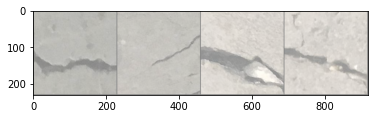

true  true  true  true 


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [ ]:
for epoch in range(10):

  running_loss = 0.0
  count = 0
  for i, data in enumerate(trainloader, 0):

    inputs, labels = data

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels.float().unsqueeze(1))
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    count += 1
    
  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / count:.3f}')

print("Finished Training")

[1,   500] loss: 0.694


KeyboardInterrupt: ignored

In [ ]:
predictions = []
ground_truth = []

for i, data in enumerate(testloader, 0):
  inputs, labels = data
  outputs = model(inputs)

  print(outputs, labels)

  #with torch.no_grad():
    #output = torch.nn.functional.softmax(model(data[0]), dim=1)
  
  #predictions += [list(op).index(max(list(op))) for op in output]
  #ground_truth += labels
